# import

In [573]:
## on nuke, we use env `anaconda3` due to `base` being outdated

import os
import pickle
from tqdm import tqdm
from IPython.display import clear_output

import numpy as np
from numpy import dot
from numpy.linalg import norm

import scipy.io as sio
import scipy.stats as stats
from scipy.stats import ttest_rel

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth'] = 2 # x and y axis thick
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none' # export svg compatible with coreldraw
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load df tidy

In [585]:
dir_mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = os.path.join(dir_mat_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LM = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_V1 = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LI') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & (data_info.manual_seg != 'TODO') # 2 LI data still need manual segm
                 & (data_info.note.str.contains('bad') != True) # exclude bad data
                 ]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LI = meta.copy()

meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
# meta

area
LM    22
Name: count, dtype: int64 22
area
V1    6
Name: count, dtype: int64 6
area
LI    18
Name: count, dtype: int64 18


In [586]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in tqdm(range(nset)):
    # print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    # sess = '00' + meta.loc[iset, 'num'].astype(str)
    sess = meta.loc[iset, 'num']
    # print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_continuous_vis_pval.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()
df_tidy['datesess'] = df_tidy.date.astype(str) + '_' + df_tidy.sess.astype(str)

# fig1: single cell trace across single trials
one noisy cell, one well-fit cell

## find session with good trace

In [49]:
# df_tidy[(df_tidy.area == 'LM') & (df_tidy.filter_cell_vis == True)].groupby('datesess').filter_cell_well_fit.sum().sort_values(ascending=False).head()
# df_tidy[(df_tidy.area == 'V1') & (df_tidy.filter_cell_vis == True)].groupby('datesess').filter_cell_well_fit.sum().sort_values(ascending=False).head()

select_datesess = '230302_003    '.strip()
df_now = df_tidy[df_tidy.datesess == select_datesess]
area_imouse_date_sess = df_now.area.unique()[0] + '_i' + df_now.mouse.unique()[0] + '_' + select_datesess
area_imouse_date_sess

'LM_i1373_230302_003'

In [50]:
dir_mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_sess_trace = os.path.join(dir_mat_inter, area_imouse_date_sess, 'trace_trial_stim.mat')

try:
    trace = sio.loadmat(dir_sess_trace)
except:
    area_imouse_date_sess = area_imouse_date_sess + '_cellpose'
    dir_sess_trace = os.path.join(dir_mat_inter, area_imouse_date_sess, 'trace_trial_stim.mat')
    trace = sio.loadmat(dir_sess_trace)
trace_by_trial = trace['trace_by_trial']
ncell = trace_by_trial.shape[0]
ntrial = trace_by_trial.shape[1]
nframe = trace_by_trial.shape[2]

print(f'ncell={ncell}, ntrial={ntrial}, nframe={nframe}')

ncell=139, ntrial=502, nframe=207


## find cells with large adp and R2

In [21]:
R2 = (df_tidy[(df_tidy.datesess == select_datesess) 
        & (df_tidy.filter_cell_vis == True) & (df_tidy.filter_cell_well_fit == True) 
        & (df_tidy.stim2_id == 0)
        & (df_tidy.isi == 250) & (df_tidy.resp_id == 'R2')
        ]
        .groupby('cell_id').dfof.mean()
        .reset_index().rename(columns={'dfof': 'R2'}))

R1 = (df_tidy[(df_tidy.datesess == select_datesess) 
        & (df_tidy.filter_cell_vis == True) & (df_tidy.filter_cell_well_fit == True) 
        & (df_tidy.stim2_id == 0)
        & ( 
           ((df_tidy.isi == 6000) & (df_tidy.resp_id == 'R2')) | 
           (df_tidy.resp_id == 'R1') )
        ]
        .groupby('cell_id').dfof.mean()
        .reset_index().rename(columns={'dfof': 'R1'}))

df_adp = pd.merge(R1, R2, on='cell_id')
df_adp['adp'] = (df_adp.R2 - df_adp.R1) / (df_adp.R1 + 1e-7)
df_adp = df_adp[(df_adp.R1 > 0) & (df_adp.R2 > 0.05)].sort_values('adp', ascending=True).reset_index(drop=True)
df_adp.head(10)

,cell_id,R1,R2,adp
0,230302_003_128,0.719837,0.295017,-0.590161
1,230302_003_81,0.304889,0.135118,-0.556830
2,230302_003_31,0.122934,0.054708,-0.554980
3,230302_003_70,0.143168,0.070537,-0.507312
4,230302_003_108,0.396317,0.208138,-0.474820
5,230302_003_127,0.179214,0.096002,-0.464317
6,230302_003_87,0.120051,0.075011,-0.375177
7,230302_003_58,0.129303,0.086960,-0.327471
8,230302_003_82,0.211765,0.145759,-0.311697
9,230302_003_89,0.212922,0.156721,-0.263952


In [22]:
## select example cells

cell_id = df_adp.head(10).cell_id.values
cell_id = [item.split('_')[-1] for item in cell_id]
cell_id = [int(item) for item in cell_id]
cell_id

[128, 81, 31, 70, 108, 127, 87, 58, 82, 89]

In [23]:
## select example trials (stim2 = 0, isi = 250, resp_id = R2)

trial_id = df_tidy[(df_tidy.datesess == select_datesess) 
            & (df_tidy.stim2_id == 0)
            & (df_tidy.isi == 250) & (df_tidy.resp_id == 'R2')
            ].trial_id.unique()
trial_id

array([  8,  41,  47, 104, 105, 140, 167, 188, 189, 214, 251, 269, 293,
       304, 328, 329, 340, 345, 372, 416, 426, 439, 450, 454, 482, 494],
      dtype=int64)

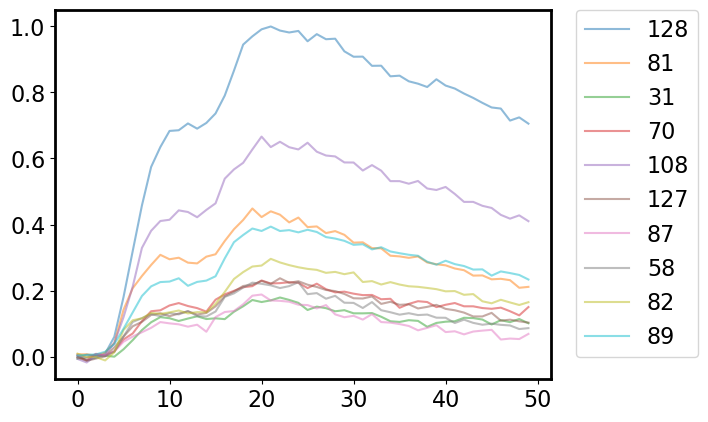

In [24]:
## choose cell by nice avg trace 

for icell in cell_id:
    trace_avg_cell = trace_by_trial[icell, trial_id, :50].mean(axis=0)
    plt.plot(trace_avg_cell, alpha=0.5);
plt.legend(cell_id, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

## single cell single trial trace

In [77]:
tail_frame_start = 190 # trace tail starts from this frame
frame_shift = nframe - tail_frame_start # length of trace tail
nframe_plot = 80 # number of frames to plot

trace_by_trial_tail = trace_by_trial[:, :, tail_frame_start:]
trace_by_trial_tail = trace_by_trial_tail - ((trace_by_trial[:, :, -1] - trace_by_trial[:, :, 0])).reshape(ncell, ntrial, 1)
trace_by_trial_head = trace_by_trial[:, :, :tail_frame_start]
trace_by_trial_reorder = np.concatenate((trace_by_trial_tail, trace_by_trial_head), axis=2)
trace_by_trial_reorder = trace_by_trial_reorder[:, :, :nframe_plot]

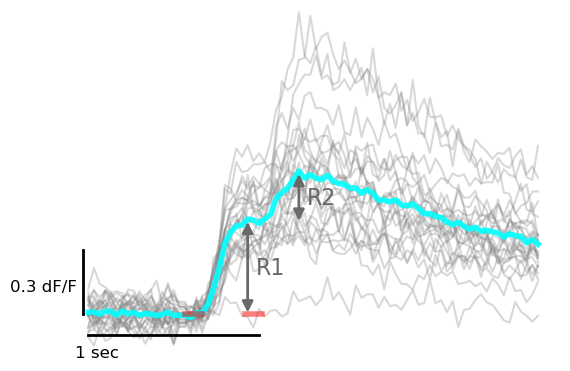

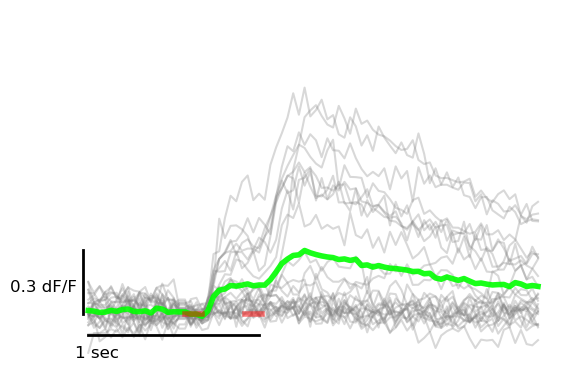

In [103]:
cell_id_example = [108, 82]
ylim_lower = trace_by_trial_reorder[cell_id_example, :, :]
ylim_lower = ylim_lower[:, trial_id, :].min() - 0.01
ylim_upper = trace_by_trial_reorder[cell_id_example, :, :]
ylim_upper = ylim_upper[:, trial_id, :].max() + 0.01
color_arr = ['cyan', 'lime']

for icell, single_cell_id in enumerate(cell_id_example):
    plt.figure(figsize=(6, 4))

    for itrial in trial_id:
        trace_trial = trace_by_trial_reorder[single_cell_id, itrial, :]
        plt.plot(trace_trial, alpha=0.3, color='gray');

    trace_agg_cell = trace_by_trial_reorder[single_cell_id, trial_id, :].mean(axis=0)
    plt.plot(trace_agg_cell, alpha=0.9, linewidth=4, color=color_arr[icell]);

    ## stim R1 and R2 arrow, only for the first cell
    if icell == 0:
        base1_id = 0 + frame_shift
        stim1_id = 11 + frame_shift
        base2_id = 13 + frame_shift
        # plt.axvline(base2_id, linestyle='--', color='dimgray', linewidth=2)
        stim2_id = 20 + frame_shift
        plt.annotate(text='', xy=(stim1_id, trace_agg_cell[base1_id]), xytext=(stim1_id, trace_agg_cell[stim1_id]), \
                    arrowprops=dict(arrowstyle='<|-|>', linewidth=2, color='dimgray'));
        plt.annotate(text='', xy=(stim2_id, trace_agg_cell[base2_id]), xytext=(stim2_id, trace_agg_cell[stim2_id]), \
                    arrowprops=dict(arrowstyle='<|-|>', linewidth=2, color='dimgray'));
    
        ## add text for arrow
        buffer_space = 4
        adjust_down_space = 0.06
        plt.text(stim1_id + buffer_space, (trace_agg_cell[stim1_id] + trace_agg_cell[base1_id]) / 2 - adjust_down_space, \
                'R1', ha='center', va='bottom', fontsize=16, color='dimgray')
        plt.text(stim2_id + buffer_space, (trace_agg_cell[stim2_id] + trace_agg_cell[base2_id]) / 2 - adjust_down_space, \
                'R2', ha='center', va='bottom', fontsize=16, color='dimgray')

    
    ## stim onset and offset
    frame_rate = 30
    stim1_sec = 0.100
    isi_sec = 0.250
    stim2_sec = 0.100
    stim1_time = np.arange(0 + frame_shift, 
                        frame_rate * stim1_sec + frame_shift, 
                        0.01)
    stim2_time = np.arange(frame_rate * (stim1_sec + isi_sec) + frame_shift, 
                        frame_rate * (stim1_sec + isi_sec + stim2_sec) + frame_shift, 
                        0.01)
    y = np.ones(stim1_time.shape) * 0
    plt.plot(stim1_time, y, linewidth=4, color='r', alpha=0.5) # plot stim onset time
    plt.plot(stim2_time, y, linewidth=4, color='r', alpha=0.5);


    ## vertical scale bar at x=-2, y=[0, 0.25]
    plt.plot([-1, -1], [0, 0.3], linewidth=2, color='k');
    ## text on the left of the scale bar
    plt.text(-2, 0.125, '0.3 dF/F', ha='right', va='center', fontsize=12);

    ## horizontal scale bar at x=[0, 30], y=0
    plt.plot([0, frame_rate * 1], [-0.1, -0.1], linewidth=2, color='k');
    ## text on the bottom of the scale bar
    plt.text(1.5, -0.15, '1 sec', ha='center', va='top', fontsize=12);


    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.xticks([])
    plt.yticks([]);
    plt.ylim(ylim_lower, ylim_upper);
    plt.tight_layout();

    dir_fig = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
    plt.savefig(dir_fig + f'fig1_example_single_vis_cell_single_trial_trace_{single_cell_id}_{area_imouse_date_sess}.svg')

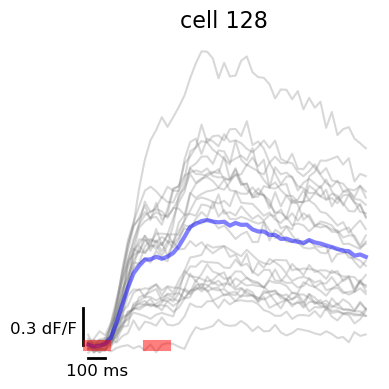

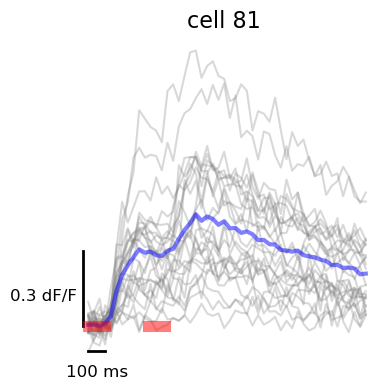

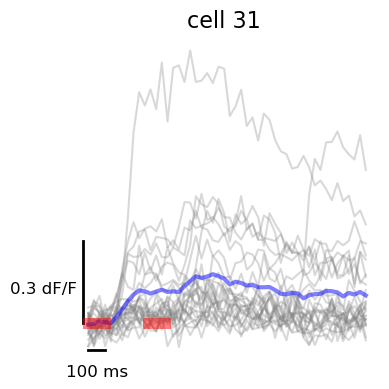

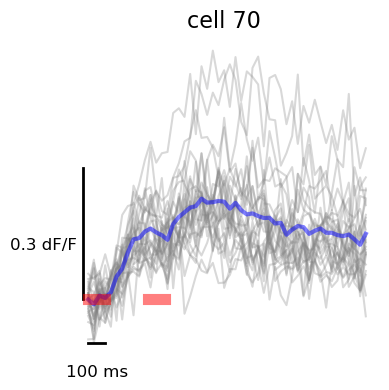

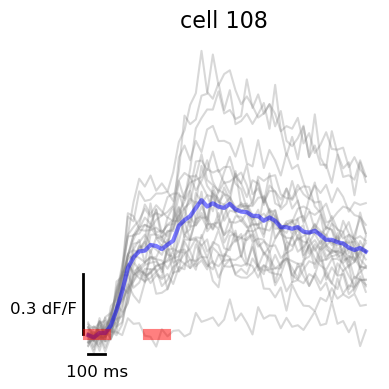

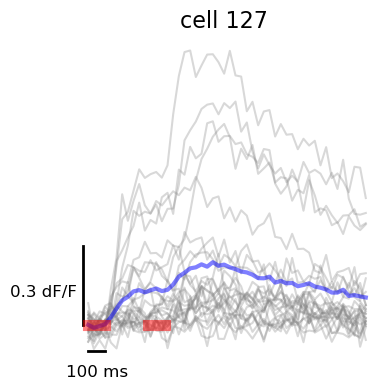

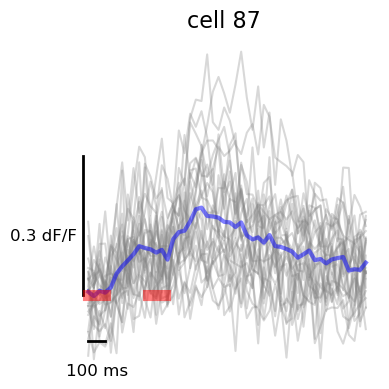

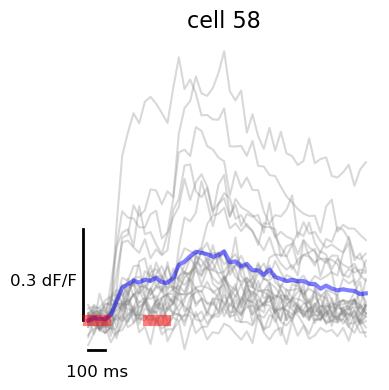

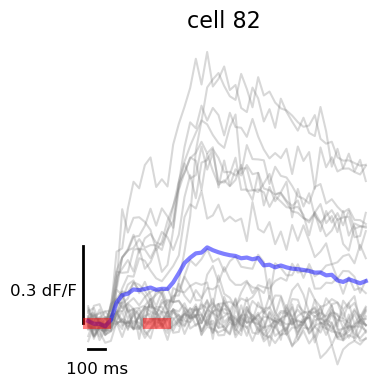

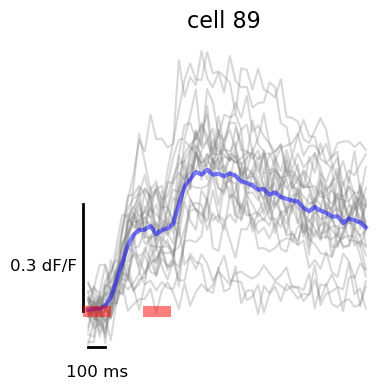

In [12]:
for single_cell_id in cell_id:
    plt.figure(figsize=(4, 4))

    # ylim_upper = 1.3
    ylim_lower = trace_by_trial[single_cell_id, trial_id, :50].min() - 0.01

    for itrial in trial_id:
        trace_trial = trace_by_trial[single_cell_id, itrial, :50]
        plt.plot(trace_trial, alpha=0.3, color='gray');
        # if trace_trial.max() <= ylim_upper:
        #     plt.plot(trace_trial, alpha=0.3, color='gray');
        # else:
        #     print(f'itrial={itrial}, max={round(trace_trial.max(), 2)}')

    trace_agg_cell = trace_by_trial[single_cell_id, trial_id, :50].mean(axis=0)
    # trace_agg_cell = np.median(trace_by_trial[single_cell_id, trial_id, :50], axis=0)
    plt.plot(trace_agg_cell, alpha=0.5, linewidth=3, color='blue');

    # plt.ylim(ylim_lower, ylim_upper);
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.xticks([])
    plt.yticks([]);

    ## vertical scale bar at x=-2, y=[0, 0.25]
    plt.plot([-1, -1], [0, 0.3], linewidth=2, color='k');
    ## text on the left of the scale bar
    plt.text(-2, 0.125, '0.3 dF/F', ha='right', va='center', fontsize=12);

    ## horizontal scale bar at x=[0, 30], y=0
    plt.plot([0, 3], [-0.1, -0.1], linewidth=2, color='k');
    ## text on the bottom of the scale bar
    plt.text(1.5, -0.15, '100 ms', ha='center', va='top', fontsize=12);

    frame_shift = 0
    frame_rate = 30
    stim1_sec = 0.100
    isi_sec = 0.250
    stim2_sec = 0.100

    stim1_time = np.arange(0 + frame_shift, 
                        frame_rate * stim1_sec + frame_shift, 
                        0.01)
    stim2_time = np.arange(frame_rate * (stim1_sec + isi_sec) + frame_shift, 
                        frame_rate * (stim1_sec + isi_sec + stim2_sec) + frame_shift, 
                        0.01)
    y = np.ones(stim1_time.shape) * 0
    plt.plot(stim1_time, y, linewidth=8, color='r', alpha=0.5) # plot stim onset time
    plt.plot(stim2_time, y, linewidth=8, color='r', alpha=0.5);

    plt.title(f'cell {single_cell_id}', fontsize=16);
    plt.tight_layout();

    dir_fig = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
    # plt.savefig(dir_fig + r'fig1_example_single_vis_cell_single_trial_trace.pdf')

# fig1: adaptation stability across trials
using new grat1  copied from grat1_mix50.ipynb  
inherited from [grat_SF6.ipynb from commit b8bb879](https://github.com/lanluo9/inter/blob/b8bb879ec03cdbd92b34296dc625f5f42966f6b2/scripts/ipynb/grat_SF6.ipynb)  
to get C:/Users/ll357/Documents/inter/results/R01/adp_stability_group_trials_grat1_plotly.svg

In [105]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [123]:
dir_csv = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1380_230207_cellpose'.replace('\\', '/')
filename = 'df_tidy.csv'
df_tidy = pd.read_csv(os.path.join(dir_csv, filename))
trial_ok = df_tidy.groupby('trial_id').filter_trial.first().astype(bool).values

mouse = 1380
date = 230207
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'
dir_data += f'V1_i{mouse}_{date}_cellpose'
stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)

# get resp_ad and resp_tg [cell x trial]
base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:,:,9:11+1].mean(axis=2)
resp_ad = resp_ad - base1
base2 = trace_by_trial[:,:,13:14+1].mean(axis=2)
resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
resp_tg = resp_tg - base2
resp_ad.shape, resp_tg.shape

ncell: 135, nstim: 1, ntrial: 1257, nframe: 257


((135, 1257), (135, 1257))

In [147]:
mean_or_median = np.median # for population, median is better than mean

resp_ad_pop = mean_or_median(resp_ad, axis=0) # population response as avg or median of all cells for each trial
resp_tg_pop = mean_or_median(resp_tg, axis=0)
adp_norm_diff = (resp_tg_pop - resp_ad_pop) / (resp_ad_pop + 1e-7) # difference over baseline
adp_IOU = (resp_tg_pop - resp_ad_pop) / (resp_tg_pop + resp_ad_pop + 1e-7) # difference over sum
# adp_norm_diff.shape, mean_or_median(adp_norm_diff), mean_or_median(adp_IOU) # group_size = 1, use all cell resp mean or median


# shuffle resp_ad_pop and resp_tg_pop the same way
np.random.seed(42)
idx = np.random.permutation(resp_ad_pop.shape[0])
resp_ad_pop_shuf = resp_ad_pop[idx]
resp_tg_pop_shuf = resp_tg_pop[idx]

# for whole population, loop thru trial numbers to group together to get a stable adaptation value  
adp_agg = []
adp_std = []
for group_size in np.arange(1, trace_by_trial.shape[1] // 10): # >= 10 groups of trials
    ngroup = trace_by_trial.shape[1] // group_size

    resp_ad_cut = resp_ad_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size) # reshape to ngroup x group_size
    resp_tg_cut = resp_tg_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size)
    resp_ad_group = mean_or_median(resp_ad_cut, axis=1) # aggregate resp within group of trials
    resp_tg_group = mean_or_median(resp_tg_cut, axis=1)

    adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7) # calc adp with `avg resp within group`
    adp_group_agg = mean_or_median(adp_group) # agg adp across group
    adp_group_std = np.std(adp_group) # std of adp across group
    adp_agg.append(adp_group_agg) # group_size variable, all cell resp agg
    adp_std.append(adp_group_std)

adp_agg = np.array(adp_agg)
adp_std = np.array(adp_std)
adp_sem = adp_std / np.sqrt(adp_std.shape[0])

In [148]:
mean_or_median = np.median # for single cell, median is better than mean too

ncell = trace_by_trial.shape[0]
ngroup_min = 2
nsize = len(np.arange(1, trace_by_trial.shape[1] // ngroup_min)) # how many group_size to test
adp_cell_agg = np.zeros((ncell, nsize))
adp_cell_std = np.zeros((ncell, nsize))
adp_cell_sem = np.zeros((ncell, nsize))

for icell in np.arange(ncell):
    resp_ad_cell = resp_ad[icell, :]
    resp_tg_cell = resp_tg[icell, :]

    # shuffle resp_ad_pop and resp_tg_pop the same way
    np.random.seed(42)
    idx = np.random.permutation(resp_ad_pop.shape[0])
    resp_ad_cell_shuf = resp_ad_cell[idx]
    resp_tg_cell_shuf = resp_tg_cell[idx]

    for isize, group_size in enumerate(np.arange(1, trace_by_trial.shape[1] // ngroup_min)):
        ngroup = trace_by_trial.shape[1] // group_size

        resp_ad_cut = resp_ad_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_tg_cut = resp_tg_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_ad_group = np.sum(resp_ad_cut, axis=1)
        resp_tg_group = np.sum(resp_tg_cut, axis=1)

        adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7)
        adp_group_agg = mean_or_median(adp_group)
        adp_group_std = np.std(adp_group)
        adp_group_sem = adp_group_std / np.sqrt(adp_group.shape[0])
        adp_cell_agg[icell, isize] = adp_group_agg
        adp_cell_std[icell, isize] = adp_group_std
        adp_cell_sem[icell, isize] = adp_group_sem

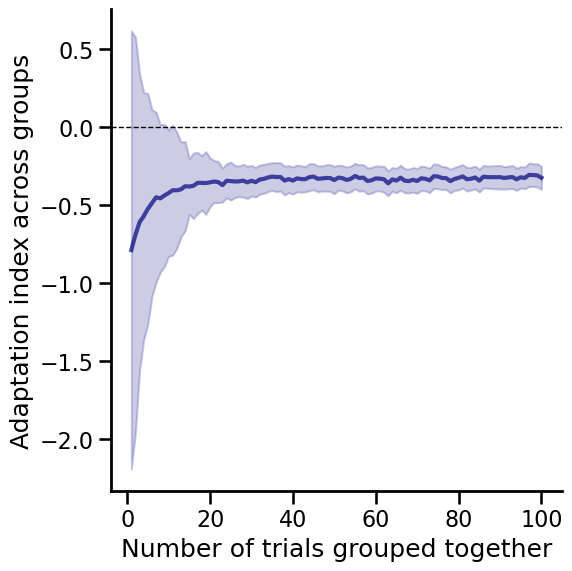

In [582]:
fig = plt.figure(figsize=(6, 6))
# fig.set_size_inches(1, 1)

x = np.arange(1, adp_agg.shape[0]+1)
xlim = 100

## single cell adp stability
adp_cell_agg_agg = mean_or_median(adp_cell_agg, axis=0)
adp_cell_std_agg = mean_or_median(adp_cell_std, axis=0)
adp_cell_sem_agg = mean_or_median(adp_cell_sem, axis=0) # agg adp error between groups -> agg across cells
errbar = adp_cell_sem_agg
plt.plot(x[:xlim], adp_cell_agg_agg[:xlim], 
         '-', color='navy', linewidth=3, alpha=0.7, label='Single neurons')
plt.fill_between(x[:xlim],  
                adp_cell_agg_agg[:xlim] + errbar[:xlim], 
                adp_cell_agg_agg[:xlim] - errbar[:xlim], 
                color='navy', alpha=0.2)

# ## population adp stability
# errbar = adp_sem 
# plt.plot(x[:xlim], adp_agg[:xlim], 
#          '-', color='lightcoral', linewidth=3, alpha=0.7, label='Population')
# plt.fill_between(x[:xlim], 
#                  adp_agg[:xlim] + errbar[:xlim], 
#                  adp_agg[:xlim] - errbar[:xlim], 
#                  color='lightcoral', alpha=0.5)


plt.axhline(0, color='k', linewidth=1, linestyle='--')
plt.xticks(np.arange(0, xlim+1, 20))
plt.xlabel('Number of trials grouped together', fontsize=18)
plt.ylabel('Adaptation index across groups', fontsize=18)
# plt.legend(fontsize=18, loc='lower right', frameon=False);
sns.despine();
plt.tight_layout()
plt.show()

figpath = r'C:\Users\ll357\Documents\inter\results\grat_work_fig'.replace('\\', '/')
# fig.savefig(os.path.join(figpath, 'adp_stability_single_cell.svg'))

# fig2: adaptation violin plot across areas
see grat8ori_fig_separate.ipynb

# fig2: grand avg trace across areas

In [592]:
dir_mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_fig = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')


def trace_longer_baseline(trace_by_trial, tail_frame_start=180, nframe_plot=90):

    ncell = trace_by_trial.shape[0]
    ntrial = trace_by_trial.shape[1]

    trace_by_trial_tail = trace_by_trial[:, :, tail_frame_start:]
    trace_by_trial_tail = trace_by_trial_tail - ((trace_by_trial[:, :, -1] - trace_by_trial[:, :, 0])).reshape(ncell, ntrial, 1)
    trace_by_trial_head = trace_by_trial[:, :, :tail_frame_start]

    trace_by_trial_reorder = np.concatenate((trace_by_trial_tail, trace_by_trial_head), axis=2)
    trace_by_trial_reorder = trace_by_trial_reorder[:, :, :nframe_plot]

    return trace_by_trial_reorder


def trace_grand_avg_area(df_tidy, select_area='V1', tail_frame_start=180):
    df_fig2 = df_tidy.copy() # df_tidy comes from section "load df tidy"
    df_fig2 = df_fig2[(df_fig2.area == select_area)
                    & (df_fig2.isi == 250) & (df_fig2.stim2_id == 0)
                    & (df_fig2.resp_id == 'R2')
                    & (df_fig2.filter_cell_vis == True)
                    ]

    trace_by_cell_concat = np.array([])
    for idatesess in tqdm(df_fig2.datesess.unique()):
        
        df_now = df_fig2[df_fig2.datesess == idatesess]
        try:
            area_imouse_date_sess = df_now.area.unique()[0] + '_i' + df_now.mouse.unique()[0] + '_' + idatesess
            dir_sess_trace = os.path.join(dir_mat_inter, area_imouse_date_sess, 'trace_trial_stim.mat')
            trace = sio.loadmat(dir_sess_trace)
        except:
            area_imouse_date_sess = area_imouse_date_sess + '_cellpose'
            dir_sess_trace = os.path.join(dir_mat_inter, area_imouse_date_sess, 'trace_trial_stim.mat')
            trace = sio.loadmat(dir_sess_trace)
        trace_by_trial = trace['trace_by_trial']
        trace_by_trial = trace_longer_baseline(trace_by_trial, tail_frame_start=tail_frame_start)

        cell_id = df_now.cell_id.unique()
        cell_id = [item.split('_')[-1] for item in cell_id]
        cell_id = [int(item) for item in cell_id]
        trial_id = df_now.trial_id.unique()

        nframe_keep = 200
        trace_filtered = trace_by_trial[cell_id, :, :nframe_keep]
        trace_filtered = trace_filtered[:, trial_id, :nframe_keep]
        trace_by_cell = np.mean(trace_filtered, axis=1) # ncell x nframe, avg across trials of isi=250, ori=0
        
        if trace_by_cell_concat.size == 0:
            trace_by_cell_concat = trace_by_cell
        else: ## stack trace_by_cell onto trace_by_cell_concat
            trace_by_cell_concat = np.vstack([trace_by_cell_concat, trace_by_cell])

    print(trace_by_cell_concat.shape)
    trace_grand_avg = np.mean(trace_by_cell_concat, axis=0)
    trace_grand_sem = np.std(trace_by_cell_concat, axis=0) / np.sqrt(trace_by_cell_concat.shape[0])

    return trace_grand_avg, trace_grand_sem

In [593]:
frame_shift_sec = 0.5 # keep 0.5 sec of trace tail (baseline) for each trial
frame_rate = 30 # unit = frame/sec
frame_shift = int(frame_shift_sec * frame_rate) # length of trace tail, unit = frame
tail_frame_start = nframe - frame_shift # trace tail starts from this frame
nframe_plot = 90 # number of frames to plot


trace_avg_V1, trace_sem_V1 = trace_grand_avg_area(df_tidy, select_area='V1', tail_frame_start=tail_frame_start)
trace_avg_LM, trace_sem_LM = trace_grand_avg_area(df_tidy, select_area='LM', tail_frame_start=tail_frame_start)
trace_avg_LI, trace_sem_LI = trace_grand_avg_area(df_tidy, select_area='LI', tail_frame_start=tail_frame_start)

trace_avg_list = [trace_avg_V1, trace_avg_LM, trace_avg_LI]
trace_sem_list = [trace_sem_V1, trace_sem_LM, trace_sem_LI]
area_list = ['V1', 'LM', 'LI']
color_list = ['#85A7EB', '#F6CD51', '#D1A6DE']


## save to pickle
trace_area = {'trace_avg_list': trace_avg_list,
             'trace_sem_list': trace_sem_list,
             'area_list': area_list,
             'color_list': color_list}
with open(dir_fig + 'trace_area_baseline_500ms.pkl', 'wb') as f:
    pickle.dump(trace_area, f)


## load from pickle
with open(dir_fig + 'trace_area_baseline_500ms.pkl', 'rb') as f:
    trace_area = pickle.load(f)

trace_avg_list = trace_area['trace_avg_list']
trace_sem_list = trace_area['trace_sem_list']
area_list = trace_area['area_list']
color_list = trace_area['color_list']

100%|██████████| 6/6 [00:02<00:00,  2.42it/s]


(449, 90)


100%|██████████| 22/22 [00:07<00:00,  2.95it/s]


(983, 90)


100%|██████████| 15/15 [00:02<00:00,  5.59it/s]

(222, 90)


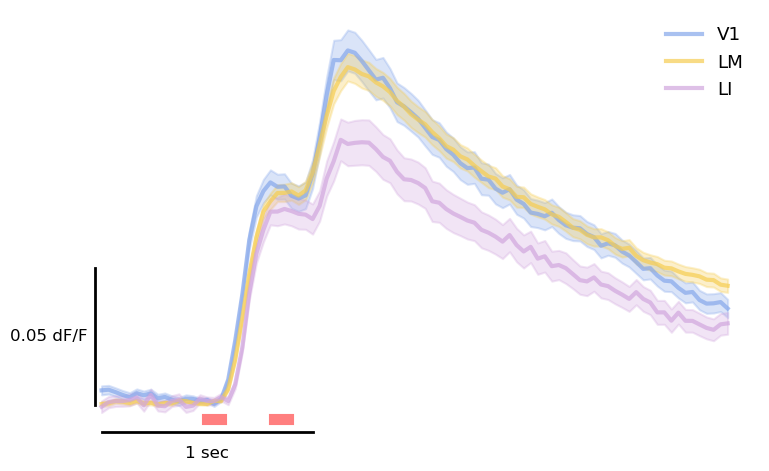

In [595]:
# plot trace avg and sem
plt.figure(figsize=(8, 5))

for iarea, area in enumerate(area_list):
	trace_grand_avg = trace_avg_list[iarea]
	trace_grand_sem = trace_sem_list[iarea]
	
	# trace_grand_avg = trace_longer_baseline(trace_grand_avg)
	# trace_grand_sem = trace_longer_baseline(trace_grand_sem)

	plt.plot(trace_grand_avg, 
		  alpha=0.7, linewidth=3, 
		  color=color_list[iarea], 
		  label=area
		  )
	plt.fill_between(np.arange(trace_grand_avg.shape[0]),
			trace_grand_avg - trace_grand_sem, 
			trace_grand_avg + trace_grand_sem,
			alpha=0.3, 
			color=color_list[iarea]
			)


# plot stim-on time
# 100 ms first stim (onset at 0 frame), 30 frame/sec -> 30*0.1 = 3 frames
# after 250 ms ISI, second stim onset: 0.25*30 = 7.5 frames
# 100 ms second stim: 0.1*30 = 3 frames
# first stim bar: frame 0 to frame 2
# second stim bar: frame 9.5 to frame 11.5
stim1_time = np.arange(0, 2, 0.01) + frame_shift
stim2_time = np.arange(9.5, 11.5, 0.01) + frame_shift
y = np.ones(stim1_time.shape) * (-0.005)
plt.plot(stim1_time, y, linewidth=8, color='r', alpha=0.5)
plt.plot(stim2_time, y, linewidth=8, color='r', alpha=0.5)


## vertical scale bar at x=-2, y=[0, 0.25]
plt.plot([-1, -1], [0, 0.05], linewidth=2, color='k');
## text on the left of the scale bar
plt.text(-2, 0.025, '0.05 dF/F', ha='right', va='center', fontsize=12);

## horizontal scale bar at x=[0, 30], y=0
plt.plot([0, frame_rate * 1], [-0.01, -0.01], linewidth=2, color='k');
## text on the bottom of the scale bar
plt.text(frame_rate / 2, -0.015, '1 sec', ha='center', va='top', fontsize=12);


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.legend(frameon=False);
plt.tight_layout();

# plt.savefig(dir_fig + '/fig2_trace_grand_avg_across_area_baseline500ms_scalebar.svg')

# fig3: tuning bias across areas
see grat8ori_fig_separate.ipynb

# fig4: decorr

## read csv for well-max

In [226]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_tuning_bias_wellmax.csv'), index=False) # takes 80 sec
df_tidy = pd.read_csv(os.path.join(dir_data, 'df_tidy_tuning_bias_wellmax.csv'))
df_tidy.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,date,sess,filter_cell_well_max,pref_ori_noad,pref_ori_ad_250,pref_ori_ad_750,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
1535086,0.070788,230302_004_53,353,R2,750,1,3,LM,0,True,...,230302,4,True,5,3,3,67.5,90,67.5,0.0
1498362,-0.001468,230302_004_10,50,R2,250,1,7,LM,0,True,...,230302,4,False,0,0,7,0.0,0,0.0,0.0
10251,-0.030888,200720_003_13,84,R1,250,1,6,V1,0,True,...,200720,3,True,0,0,0,0.0,0,0.0,0.0
26153,-0.020128,200720_003_33,401,R1,250,1,0,V1,0,False,...,200720,3,True,7,7,3,22.5,0,22.5,0.0
1794444,0.021428,230307_004_31,149,R2,250,1,3,LM,0,False,...,230307,4,True,6,6,7,45.0,45,45.0,0.0


In [567]:
pd.options.mode.chained_assignment = None  # default='warn' # suppress SettingWithCopyWarning

def get_df_decorr(df_tidy, current_area):
    df_decorr = df_tidy[['dfof', 
                        'cell_id', 'resp_id', 'isi', 'stim2_id', 
                        'filter_cell_vis', 'filter_cell_stim', 'filter_cell_well_fit', 'filter_cell_well_max',
                        'area', 'mouse', 'date', 'sess'
                        ]]

    df_decorr['stim2_dist'] = df_decorr.stim2_id.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) 
                              # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed
    df_decorr['date_sess'] = df_decorr.date.astype(str) + '_' + df_decorr.sess.astype(str)

    df_decorr = df_decorr[(df_decorr.isi != 750)
                          & (df_decorr.resp_id == 'R2') # repre of 8ori, with or without 0 deg adapter
                          & (df_decorr.area == current_area)
                          & (df_decorr.filter_cell_vis == True)
                          # & (df_decorr.filter_cell_stim == True)
                          # & (df_decorr.filter_cell_well_fit == True) # well fit doesn't help decorr
                          # & (df_decorr.filter_cell_well_max == True) # well max doesn't help 
                        ]
    return df_decorr


def cos_sim_bootstrap(df_decorr, ref_ori=90, metric='cos_sim'):
    
    nboot = 100
    sim_boots = []
    for iboot in tqdm(range(nboot)):
        np.random.seed(iboot)
        
        df_pop_vec = (df_decorr
                        .groupby(['isi', 'stim2_dist', 'cell_id'])
                        .dfof.median().reset_index() # cell-level median, under each isi-stim2_dist condition
                        .groupby(['isi', 'stim2_dist'])
                        .sample(frac=3.5, replace=True, random_state=iboot) # resample cells with replacement in each cond
                        .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof') # df allows duplicate columns
                        .fillna(0) # fill nan with 0, bc some cells are not sampled in some conditions
                      ) # rows: isi 250 -> 6000, within each isi, stim2_dist 0 -> 90. cols: cell_id
        nori = df_decorr.stim2_dist.nunique()
        nisi_now = df_decorr.isi.nunique() # discarded isi 750

        sim_iboot = []
        for iisi in range(nisi_now):
            if ref_ori == 90:
                iref = iisi*nori + 4  # -1 (0-based indexing) and +1 (go to next isi) cancel out
            elif ref_ori == 0:
                iref = iisi*nori
            else:
                print('ref_ori must be 0 or 90')
                
            pop_vec_ref = df_pop_vec.iloc[iref, :].values # reference pop vec: ref ori target resp
            for iori in range(nori): # iori = 0-4, aka ori distance from ref ori
                irow = iisi * nori + iori
                pop_vec_ori = df_pop_vec.iloc[irow, :].values

                if metric == 'cos_sim':
                    sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
                elif metric == 'dot_prod':
                    sim = dot(pop_vec_ref, pop_vec_ori)
                elif metric == 'neural_angle':
                    tmp = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
                    tmp = np.round(tmp, 4)
                    sim = np.arccos(tmp) * 180 / np.pi # cos_simil to simil rad to deg, "neural angle"

                    # sim = sim - iori*22.5 # neural angle - physical grating ori angle
                    
                    # if iori == 0:
                    #     sim = np.nan # divide by 0
                    # else:
                    #     sim = sim / (iori*22.5) # neural angle / physical grating ori angle
                sim_iboot.append(sim)

        sim_boots.append(sim_iboot) # n of decorrelation pairs (nisi * nori)    
    sim_boots = np.array(sim_boots) # n of boot x n of decorrelation pairs (nisi * nori). NOTE: isi order is 250 -> 6000
    return sim_boots

In [568]:
# df_decorr_V1 = get_df_decorr(df_tidy, current_area='V1')
# df_decorr_LM = get_df_decorr(df_tidy, current_area='LM')
# df_decorr_LI = get_df_decorr(df_tidy, current_area='LI')

# cos_sim_V1 = cos_sim_bootstrap(df_decorr_V1, ref_ori=90, metric='cos_sim')
# cos_sim_LM = cos_sim_bootstrap(df_decorr_LM, ref_ori=90, metric='cos_sim')
# cos_sim_LI = cos_sim_bootstrap(df_decorr_LI, ref_ori=90, metric='cos_sim')

# cos_sim_V1_ref0 = cos_sim_bootstrap(df_decorr_V1, ref_ori=0, metric='cos_sim')
# cos_sim_LM_ref0 = cos_sim_bootstrap(df_decorr_LM, ref_ori=0, metric='cos_sim')
# cos_sim_LI_ref0 = cos_sim_bootstrap(df_decorr_LI, ref_ori=0, metric='cos_sim')

# dot_prod_V1 = cos_sim_bootstrap(df_decorr_V1, ref_ori=90, metric='dot_prod')
# dot_prod_LM = cos_sim_bootstrap(df_decorr_LM, ref_ori=90, metric='dot_prod')
# dot_prod_LI = cos_sim_bootstrap(df_decorr_LI, ref_ori=90, metric='dot_prod')

# dot_prod_V1_ref0 = cos_sim_bootstrap(df_decorr_V1, ref_ori=0, metric='dot_prod')
# dot_prod_LM_ref0 = cos_sim_bootstrap(df_decorr_LM, ref_ori=0, metric='dot_prod')
# dot_prod_LI_ref0 = cos_sim_bootstrap(df_decorr_LI, ref_ori=0, metric='dot_prod')

# neural_angle_V1_ref0 = cos_sim_bootstrap(df_decorr_V1, ref_ori=0, metric='neural_angle')
# neural_angle_LM_ref0 = cos_sim_bootstrap(df_decorr_LM, ref_ori=0, metric='neural_angle')
# neural_angle_LI_ref0 = cos_sim_bootstrap(df_decorr_LI, ref_ori=0, metric='neural_angle')

100%|██████████| 100/100 [00:01<00:00, 57.66it/s]


### neural angle

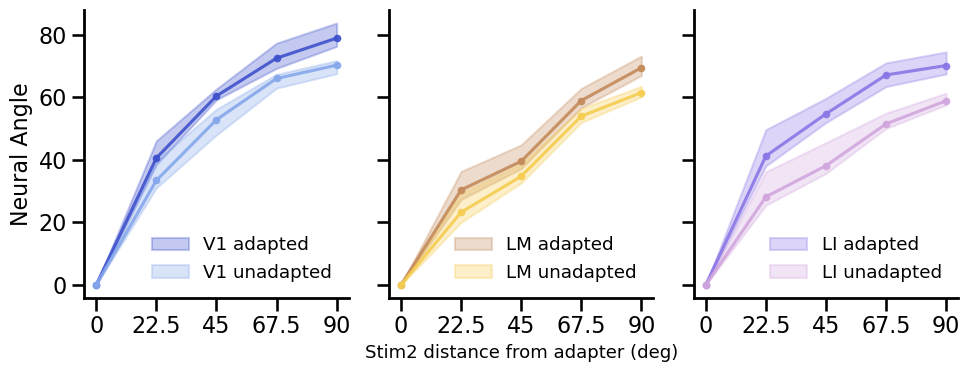

In [598]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6'
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]
area_list = ['V1', 'LM', 'LI']


for iarea, cos_sim_boots in enumerate([neural_angle_V1_ref0, neural_angle_LM_ref0, neural_angle_LI_ref0]):

    cos_sim_avg = np.mean(cos_sim_boots, axis=0) # across boots
    nori = df_decorr_V1.stim2_dist.nunique()
    perc = 2.5

    ax[iarea].plot(cos_sim_avg[:nori], color=color_list_250[iarea], alpha=0.9, marker='.')
    ax[iarea].fill_between(x=np.arange(nori),
                    y1=np.percentile(cos_sim_boots, perc, axis=0)[:nori],
                    y2=np.percentile(cos_sim_boots, 100-perc, axis=0)[:nori],
                    label=f'{area_list[iarea]} adapted',
                    color=color_list_250[iarea], alpha=0.3)

    ax[iarea].plot(cos_sim_avg[nori:], color=color_list_noad[iarea], alpha=0.9, marker='.')
    ax[iarea].fill_between(x=np.arange(nori),
                    y1=np.percentile(cos_sim_boots, perc, axis=0)[nori:],
                    y2=np.percentile(cos_sim_boots, 100-perc, axis=0)[nori:],
                    label=f'{area_list[iarea]} unadapted',
                    color=color_list_noad[iarea], alpha=0.3);

    # ## annotate ncell at top left
    # plt.text(0.05, 0.95, f'ncell={df_decorr.cell_id.nunique()}', transform=plt.gca().transAxes, fontsize=12, va='top', ha='left')

    ax[iarea].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90']);
    # ax[iarea].set_ylim(0., 1.05)
    ax[iarea].legend(frameon=False, loc='lower right')
    # ax[iarea].legend(frameon=False, loc='upper right', fontsize=12)
ax[1].set_xlabel('Stim2 distance from adapter (deg)', fontsize=13);
ax[0].set_ylabel('Neural Angle', fontsize=16);
# ax[0].set_ylabel('Neural Angle - Physical Angle', fontsize=14);
# ax[0].set_ylabel('Neural Angle per Physical Angle', fontsize=13);
sns.despine();

fig.tight_layout();
fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area, neural_angle.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

### cos simil

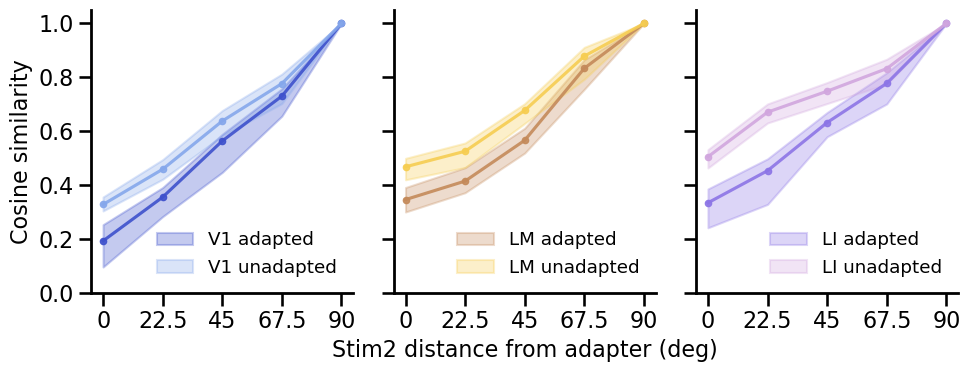

In [612]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6'
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]
area_list = ['V1', 'LM', 'LI']


for iarea, cos_sim_boots in enumerate([cos_sim_V1, cos_sim_LM, cos_sim_LI]):

    cos_sim_avg = np.mean(cos_sim_boots, axis=0) # across boots
    nori = df_decorr_V1.stim2_dist.nunique()
    perc = 2.5

    ax[iarea].plot(cos_sim_avg[:nori], color=color_list_250[iarea], alpha=0.9, marker='.')
    ax[iarea].fill_between(x=np.arange(nori),
                    y1=np.percentile(cos_sim_boots, perc, axis=0)[:nori],
                    y2=np.percentile(cos_sim_boots, 100-perc, axis=0)[:nori],
                    label=f'{area_list[iarea]} adapted',
                    color=color_list_250[iarea], alpha=0.3)

    ax[iarea].plot(cos_sim_avg[nori:], color=color_list_noad[iarea], alpha=0.9, marker='.')
    ax[iarea].fill_between(x=np.arange(nori),
                    y1=np.percentile(cos_sim_boots, perc, axis=0)[nori:],
                    y2=np.percentile(cos_sim_boots, 100-perc, axis=0)[nori:],
                    label=f'{area_list[iarea]} unadapted',
                    color=color_list_noad[iarea], alpha=0.3);

    # ## annotate ncell at top left
    # plt.text(0.05, 0.95, f'ncell={df_decorr.cell_id.nunique()}', transform=plt.gca().transAxes, fontsize=12, va='top', ha='left')

    ax[iarea].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90']);
    ax[iarea].set_ylim(0., 1.05)
    ax[iarea].legend(frameon=False, loc='lower right')
ax[1].set_xlabel('Stim2 distance from adapter (deg)', fontsize=16);
ax[0].set_ylabel('Cosine similarity', fontsize=16);
sns.despine();

fig.tight_layout();
fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area_ref90.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

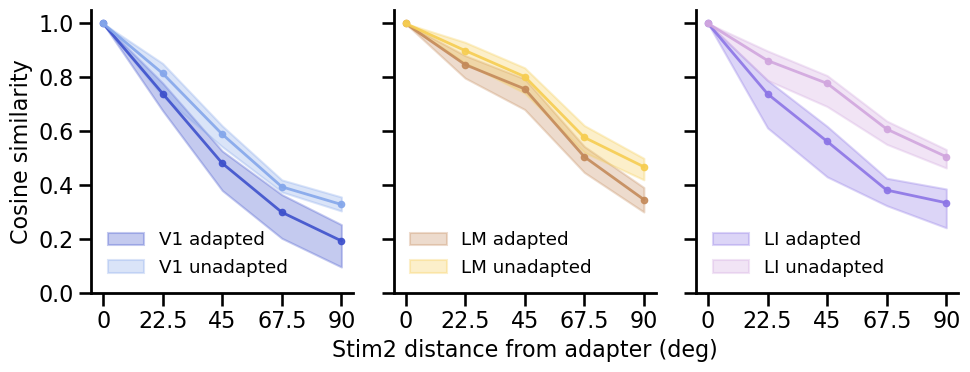

In [603]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]
area_list = ['V1', 'LM', 'LI']


for iarea, cos_sim_boots in enumerate([cos_sim_V1_ref0, cos_sim_LM_ref0, cos_sim_LI_ref0]):

    cos_sim_avg = np.mean(cos_sim_boots, axis=0) # across boots
    nori = df_decorr_V1.stim2_dist.nunique()
    perc = 2.5
    linewidth = 2

    ax[iarea].plot(cos_sim_avg[:nori], color=color_list_250[iarea], 
                   linewidth=linewidth,
                   alpha=0.9, marker='.')
    ax[iarea].fill_between(x=np.arange(nori),
                    y1=np.percentile(cos_sim_boots, perc, axis=0)[:nori],
                    y2=np.percentile(cos_sim_boots, 100-perc, axis=0)[:nori],
                    label=f'{area_list[iarea]} adapted',
                    color=color_list_250[iarea], alpha=0.3)

    ax[iarea].plot(cos_sim_avg[nori:], color=color_list_noad[iarea], 
                   linewidth=linewidth,
                   alpha=0.9, marker='.')
    ax[iarea].fill_between(x=np.arange(nori),
                    y1=np.percentile(cos_sim_boots, perc, axis=0)[nori:],
                    y2=np.percentile(cos_sim_boots, 100-perc, axis=0)[nori:],
                    label=f'{area_list[iarea]} unadapted',
                    color=color_list_noad[iarea], alpha=0.3);

    # ## annotate ncell at top left
    # plt.text(0.05, 0.95, f'ncell={df_decorr.cell_id.nunique()}', transform=plt.gca().transAxes, fontsize=12, va='top', ha='left')

    ax[iarea].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90']);
    ax[iarea].set_ylim(0., 1.05)
    ax[iarea].legend(frameon=False, loc='lower left')
ax[1].set_xlabel('Stim2 distance from adapter (deg)', fontsize=16);
ax[0].set_ylabel('Cosine similarity', fontsize=16);
sns.despine();

fig.tight_layout();
fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area_ref0_linewidth={linewidth}_recolor.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

### dot product

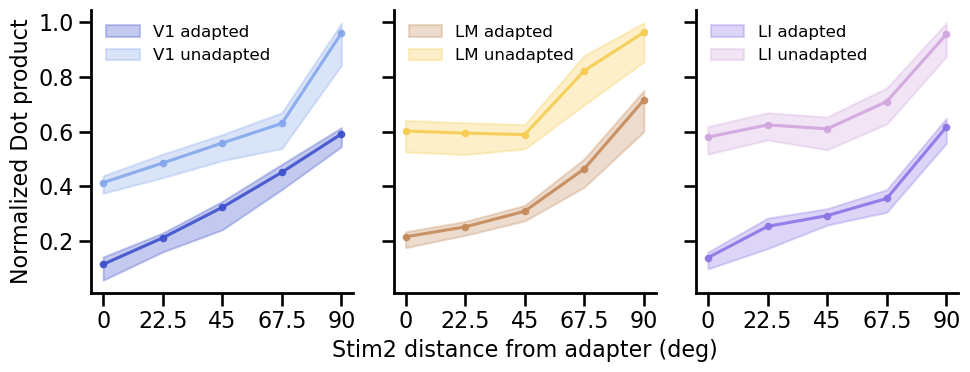

In [619]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]
area_list = ['V1', 'LM', 'LI']

## get ncell in df_decorr for each area
ncell_area = []
for df_decorr in [df_decorr_V1, df_decorr_LM, df_decorr_LI]:
    ncell_area.append(df_decorr.cell_id.nunique())

for iarea, sim_boots in enumerate([dot_prod_V1, dot_prod_LM, dot_prod_LI]):

    ## normalize sim values in sim_boots by ncell, then by max
    sim_boots = sim_boots / ncell_area[iarea]
    sim_boots = sim_boots / np.max(sim_boots)

    sim_avg = np.mean(sim_boots, axis=0) # across boots
    nori = df_decorr_V1.stim2_dist.nunique()
    perc = 2.5

    ax[iarea].plot(sim_avg[:nori], color=color_list_250[iarea], alpha=0.9, marker='.')
    ax[iarea].fill_between(x=np.arange(nori),
                    y1=np.percentile(sim_boots, perc, axis=0)[:nori],
                    y2=np.percentile(sim_boots, 100-perc, axis=0)[:nori],
                    label=f'{area_list[iarea]} adapted',
                    color=color_list_250[iarea], alpha=0.3)

    ax[iarea].plot(sim_avg[nori:], color=color_list_noad[iarea], alpha=0.9, marker='.')
    ax[iarea].fill_between(x=np.arange(nori),
                    y1=np.percentile(sim_boots, perc, axis=0)[nori:],
                    y2=np.percentile(sim_boots, 100-perc, axis=0)[nori:],
                    label=f'{area_list[iarea]} unadapted',
                    color=color_list_noad[iarea], alpha=0.3);

    # ## annotate ncell at top left
    # plt.text(0.05, 0.95, f'ncell={df_decorr.cell_id.nunique()}', transform=plt.gca().transAxes, fontsize=12, va='top', ha='left')

    ax[iarea].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90']);
    # ax[iarea].set_ylim(0., 1.05)
    ax[iarea].legend(frameon=False, loc='upper left', fontsize=12)
ax[1].set_xlabel('Stim2 distance from adapter (deg)', fontsize=16);
ax[0].set_ylabel('Normalized Dot product', fontsize=16);
sns.despine();

fig.tight_layout();
fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area_dot_prod_ref90_normed_by_ncell_&_max.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

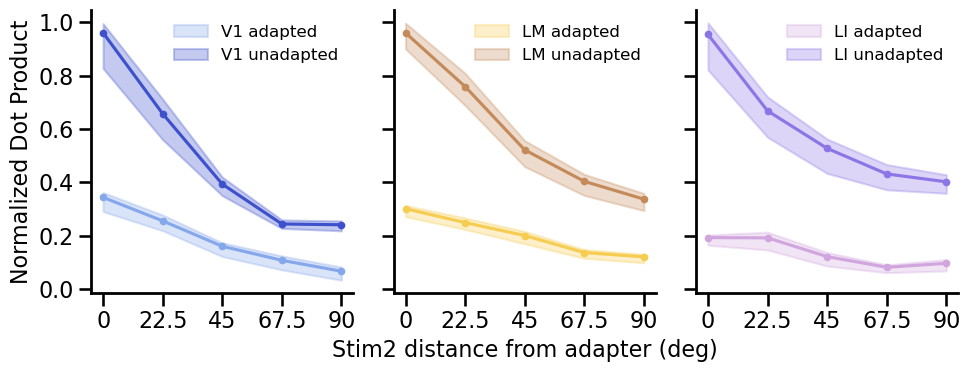

In [621]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]
area_list = ['V1', 'LM', 'LI']

## get ncell in df_decorr for each area
ncell_area = []
for df_decorr in [df_decorr_V1, df_decorr_LM, df_decorr_LI]:
    ncell_area.append(df_decorr.cell_id.nunique())

for iarea, sim_boots in enumerate([dot_prod_V1_ref0, dot_prod_LM_ref0, dot_prod_LI_ref0]):

    ## normalize sim values in sim_boots by ncell, then by max
    sim_boots = sim_boots / ncell_area[iarea]
    sim_boots = sim_boots / np.max(sim_boots)

    sim_avg = np.mean(sim_boots, axis=0) # across boots
    nori = df_decorr_V1.stim2_dist.nunique()
    perc = 2.5

    ax[iarea].plot(sim_avg[:nori], color=color_list_noad[iarea], alpha=1, marker='.')
    ax[iarea].fill_between(x=np.arange(nori),
                    y1=np.percentile(sim_boots, perc, axis=0)[:nori],
                    y2=np.percentile(sim_boots, 100-perc, axis=0)[:nori],
                    label=f'{area_list[iarea]} adapted',
                    color=color_list_noad[iarea], alpha=0.3)

    ax[iarea].plot(sim_avg[nori:], color=color_list_250[iarea], alpha=1, marker='.')
    ax[iarea].fill_between(x=np.arange(nori),
                    y1=np.percentile(sim_boots, perc, axis=0)[nori:],
                    y2=np.percentile(sim_boots, 100-perc, axis=0)[nori:],
                    label=f'{area_list[iarea]} unadapted',
                    color=color_list_250[iarea], alpha=0.3);

    # ## annotate ncell at top left
    # plt.text(0.05, 0.95, f'ncell={df_decorr.cell_id.nunique()}', transform=plt.gca().transAxes, fontsize=12, va='top', ha='left')

    ax[iarea].set_xticks(range(nori), ['0', '22.5', '45', '67.5', '90']);
    # ax[iarea].set_ylim(0., 1.05)
    ax[iarea].legend(frameon=False, loc='upper right', fontsize=12)
ax[1].set_xlabel('Stim2 distance from adapter (deg)', fontsize=16);
ax[0].set_ylabel('Normalized Dot Product', fontsize=16);
sns.despine();

fig.tight_layout();
fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area_dot_prod_ref0_normed_by_ncell_&_max.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

## schematics

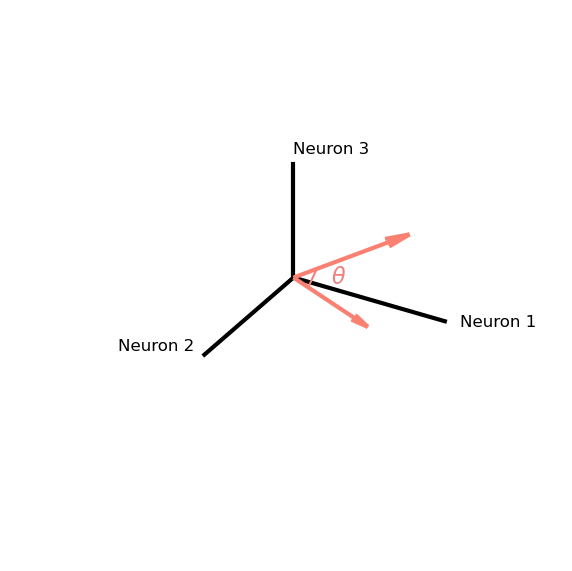

In [425]:
import mpl_toolkits.mplot3d.art3d as art3d

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_axis_off() # hide axis, which looks like a box

linewidth = 3
## draw x axis
ax.plot([0, 2], [0, 0], [0, 0], color='k', linewidth=linewidth)
## draw y axis
ax.plot([0, 0], [-2, 0], [0, 0], color='k', linewidth=linewidth)
## draw z axis
ax.plot([0, 0], [0, 0], [0, 2], color='k', linewidth=linewidth)

## draw a vector [1, 1, 0.5] as an arrow
ax.quiver(0, 0, 0, 1, 1, 0.5, color='salmon', linewidth=linewidth, arrow_length_ratio=0.2)
## draw a vector [1, 0, -0.5] as an arrow
ax.quiver(0, 0, 0, 1, 0, -0.5, color='salmon', linewidth=linewidth, arrow_length_ratio=0.2)

## connect two quivers at the tail
scale = 5
ax.plot([1/scale, 1/scale], [1/scale, 0], [0.5/scale, -0.5/scale], color='lightcoral', linewidth=linewidth/2)

## add text close to the connection line, "theta"
ax.text(0.45, 0.1, 0, r'$\theta$', fontsize=16, color='lightcoral')

## show axis label
axis_label_fontsize = 12
ax.text(2.2, 0, 0, 'Neuron 1', fontsize=axis_label_fontsize)
ax.text(-0.9, -2.4, 0, 'Neuron 2', fontsize=axis_label_fontsize)
ax.text(0, 0, 2.2, 'Neuron 3', fontsize=axis_label_fontsize)

axis_lim = 2
ax.set_xlim(-axis_lim, axis_lim)
ax.set_ylim(-axis_lim, axis_lim)
ax.set_zlim(-axis_lim, axis_lim);

plt.tight_layout()
# fig.savefig(dir_fig + '/cos_simil_schematics.svg')

# fig5: decoder
## pop vec decoder jeff

p = 0.043
p = 0.001
p = 0.005


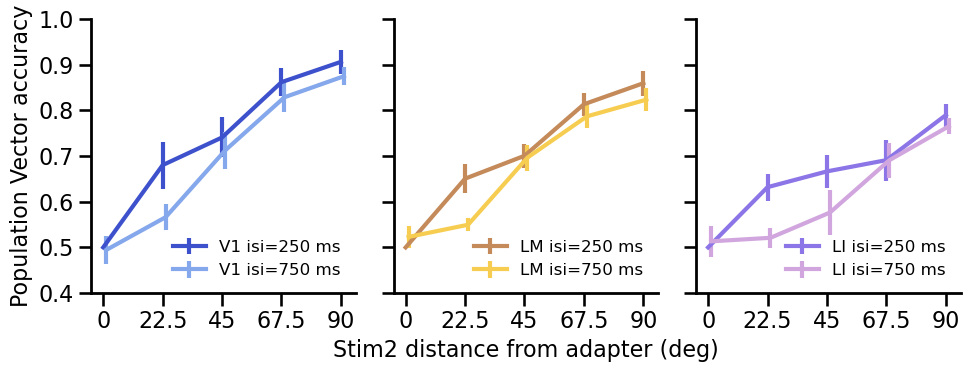

In [572]:
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6'
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]

fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
dir_pop_vec = r'C:\Users\ll357\Documents\inter\results\decoder_grat8\pop vec decoder jin2019 jeff'.replace('\\', '/')
xticklabels = ['0', '22.5', '45', '67.5', '90']

for i, iarea in enumerate(['V1', 'LM', 'LI']):

    res = sio.loadmat(os.path.join(dir_pop_vec, f'pop_vec_decoder_jeff_res_{iarea}_visp_sqrt_agg.mat'))
    acc_250 = res['tmp_250']
    acc_750 = res['tmp_750']

    ## paired t-test
    _, p = ttest_rel(acc_250[:, 1], acc_750[:, 1])
    print(f'p = {np.round(p, 3)}')

    
    ax[i].errorbar(x=np.arange(len(xticklabels)), 
                y=np.mean(acc_250, axis=0),
                yerr=np.std(acc_250, axis=0) / np.sqrt(acc_250.shape[0]),
                color=color_list_250[i], linewidth=3,
                label=f'{iarea} isi=250 ms')

    ax[i].errorbar(x=np.arange(len(xticklabels)) + 0.05,
                y=np.mean(acc_750, axis=0),
                yerr=np.std(acc_750, axis=0) / np.sqrt(acc_750.shape[0]),
                color=color_list_noad[i], linewidth=3,
                label=f'{iarea} isi=750 ms')
    
    ax[i].legend(frameon=False, loc='lower right', fontsize=12);

ax[1].set_xticks(range(len(xticklabels)))
ax[1].set_xticklabels(xticklabels)
ax[1].set_xlabel('Stim2 distance from adapter (deg)', fontsize=16)
ax[0].set_ylabel('Population Vector accuracy', fontsize=16)
plt.ylim(0.4, 1.0);
sns.despine();
plt.tight_layout();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'pop_vec_jeff_decoder_acc_across_area.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')